In [8]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import folium
from geopy.geocoders import Nominatim
import re

In [9]:
# 도시교통정보센터 - API

url = 'http://www.utic.go.kr/guide/getSafeOpenJson.do'
api_key = '9mtOhcOoc6Tx8NSTV0A751uXWLl5Kbk9hLOAEGXqb2c6JYsdqFEOZfpXkKBmy'
sidoCd = 11  # 원하는 시도 코드로 변경해주세요.

parameter = '?key={}&sidoCd={}'.format(api_key, sidoCd) 
url_with_params = url + parameter

response = requests.get(url_with_params)

json_data = response.json()

In [10]:
# 데이터프레임으로 불러오기
if 'items' in json_data:
    df = pd.DataFrame(json_data['items'])

In [11]:
# 원하는 열만 뽑아서 보기(MAX_SPD : 제한속도, SIDO_NM : 시도명, FCLTY_NM : 대상시설명, ROAD_WDT : 도로구역도로폭(NULL=O), CCTV_YN : CCTV 설치여부, LADDR : 지번주소, SIGUN_NM : 시군구명, X:경도, Y:위도, FCLTY_TY : 시설종류)
df = df[['MAX_SPD','SIDO_NM','FCLTY_NM','ROAD_WDT','CCTV_YN','LADDR','SIGUN_NM','X','Y','FCLTY_TY']]

In [12]:
# 시설종류 열 확인
df['FCLTY_TY'].unique()  # 1,2,3이라는 숫자(변수)로 시설종류(어린이, 노인, 장애인)가 이루어져 잇음
df['FCLTY_TY'].value_counts()  # 1=3127개, 2=265개, 3=16개

FCLTY_TY
1    3127
2     265
3      16
Name: count, dtype: int64

In [13]:
df[df['FCLTY_TY']=='3']  # 이렇게 확인해본 결과 1=어린이, 2=노인, 3=장애인

,MAX_SPD,SIDO_NM,FCLTY_NM,ROAD_WDT,CCTV_YN,LADDR,SIGUN_NM,X,Y,FCLTY_TY
2,30,서울특별시,동대문장애인종합복지관,0,1,서울특별시 동대문구 용두동 255-69 다사랑행복센터 동대문장애인종합복지관,동대문구,127.034084,37.571825,3
4,30,서울특별시,강남세움복지관,0,1,서울특별시 강남구 수서동 721 미미위강남세움센터 강남세움복지관,강남구,127.106944,37.486993,3
28,50,서울특별시,서울시립남부장애인 종합복지관,15,1,서울특별시 동작구 신대방동 722 서울시립남부장애인종합복지관 신대방동 722,동작구,126.916797,37.490300,3
60,30,서울특별시,홀트강동복지관,23,2,서울특별시 강동구 강일동 665-3 홀트강동복지관 홀트강동복지관,강동구,127.173289,37.566226,3
2041,30,서울특별시,늘푸른집,6~12,1,서울특별시 강서구 개화동 330 천주의성요한수도회 늘푸른집,강서구,126.811164,37.584455,3
2188,30,서울특별시,다니엘의집4호,4,2,,강남구,127.021003,37.515144,3
2189,30,서울특별시,사랑쉼터의 집,9~21,1,서울특별시 강동구 상일동 473-1 사랑쉼터의 집 사랑쉼터의집,강동구,127.167256,37.546769,3
2190,30,서울특별시,암사재활원,17,1,서울특별시 강동구 암사동 196-1 암사재활원 암사재활원,강동구,127.131414,37.558380,3
2191,30,서울특별시,늘푸른나무복지관,25,2,서울특별시 강서구 가양동 1470-2 늘푸른나무 복지관 .,강서구,126.851000,37.568492,3
2192,30,서울특별시,늘푸른나무복지관,8,1,서울특별시 강서구 가양동 1470-2 늘푸른나무 복지관 .,강서구,126.851000,37.568492,3


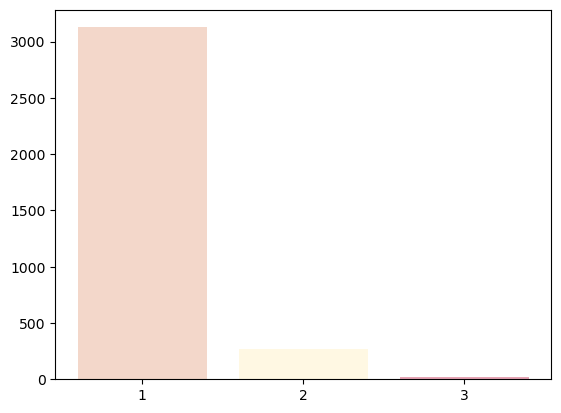

In [14]:
# <보호구역 비율 시각화>

# 'FCLTY_TY' 열의 값별 개수 계산
counts = df['FCLTY_TY'].value_counts()

# 색
c = ['#F3D7CA','#FFF8E3','#E6A4B4']

# 바 그래프 그리기
plt.bar(counts.index, counts.values, color = c)
plt.show()

In [15]:
# 한글파일을 바탕으로 만든 데이터프레임과 맞는지 확인하기
df_check = df[df['FCLTY_TY']=='3']  # 장애인 보호구역=3이여서 3으로 확인
df_check

,MAX_SPD,SIDO_NM,FCLTY_NM,ROAD_WDT,CCTV_YN,LADDR,SIGUN_NM,X,Y,FCLTY_TY
2,30,서울특별시,동대문장애인종합복지관,0,1,서울특별시 동대문구 용두동 255-69 다사랑행복센터 동대문장애인종합복지관,동대문구,127.034084,37.571825,3
4,30,서울특별시,강남세움복지관,0,1,서울특별시 강남구 수서동 721 미미위강남세움센터 강남세움복지관,강남구,127.106944,37.486993,3
28,50,서울특별시,서울시립남부장애인 종합복지관,15,1,서울특별시 동작구 신대방동 722 서울시립남부장애인종합복지관 신대방동 722,동작구,126.916797,37.490300,3
60,30,서울특별시,홀트강동복지관,23,2,서울특별시 강동구 강일동 665-3 홀트강동복지관 홀트강동복지관,강동구,127.173289,37.566226,3
2041,30,서울특별시,늘푸른집,6~12,1,서울특별시 강서구 개화동 330 천주의성요한수도회 늘푸른집,강서구,126.811164,37.584455,3
2188,30,서울특별시,다니엘의집4호,4,2,,강남구,127.021003,37.515144,3
2189,30,서울특별시,사랑쉼터의 집,9~21,1,서울특별시 강동구 상일동 473-1 사랑쉼터의 집 사랑쉼터의집,강동구,127.167256,37.546769,3
2190,30,서울특별시,암사재활원,17,1,서울특별시 강동구 암사동 196-1 암사재활원 암사재활원,강동구,127.131414,37.558380,3
2191,30,서울특별시,늘푸른나무복지관,25,2,서울특별시 강서구 가양동 1470-2 늘푸른나무 복지관 .,강서구,126.851000,37.568492,3
2192,30,서울특별시,늘푸른나무복지관,8,1,서울특별시 강서구 가양동 1470-2 늘푸른나무 복지관 .,강서구,126.851000,37.568492,3


In [16]:
# 'fclty_nm' 열을 기준으로 중복된 행 제거 => 10개의 보호구역이 나옴
new_df = df_check.drop_duplicates(subset='FCLTY_NM')
new_df

,MAX_SPD,SIDO_NM,FCLTY_NM,ROAD_WDT,CCTV_YN,LADDR,SIGUN_NM,X,Y,FCLTY_TY
2,30,서울특별시,동대문장애인종합복지관,0,1,서울특별시 동대문구 용두동 255-69 다사랑행복센터 동대문장애인종합복지관,동대문구,127.034084,37.571825,3
4,30,서울특별시,강남세움복지관,0,1,서울특별시 강남구 수서동 721 미미위강남세움센터 강남세움복지관,강남구,127.106944,37.486993,3
28,50,서울특별시,서울시립남부장애인 종합복지관,15,1,서울특별시 동작구 신대방동 722 서울시립남부장애인종합복지관 신대방동 722,동작구,126.916797,37.490300,3
60,30,서울특별시,홀트강동복지관,23,2,서울특별시 강동구 강일동 665-3 홀트강동복지관 홀트강동복지관,강동구,127.173289,37.566226,3
2041,30,서울특별시,늘푸른집,6~12,1,서울특별시 강서구 개화동 330 천주의성요한수도회 늘푸른집,강서구,126.811164,37.584455,3
2188,30,서울특별시,다니엘의집4호,4,2,,강남구,127.021003,37.515144,3
2189,30,서울특별시,사랑쉼터의 집,9~21,1,서울특별시 강동구 상일동 473-1 사랑쉼터의 집 사랑쉼터의집,강동구,127.167256,37.546769,3
2190,30,서울특별시,암사재활원,17,1,서울특별시 강동구 암사동 196-1 암사재활원 암사재활원,강동구,127.131414,37.558380,3
2191,30,서울특별시,늘푸른나무복지관,25,2,서울특별시 강서구 가양동 1470-2 늘푸른나무 복지관 .,강서구,126.851000,37.568492,3
3265,30,서울특별시,신아재활원,11,1,서울특별시 송파구 거여동 251-23 신아원 신아재활원,송파구,127.145469,37.491457,3


-> 한글파일과 비교해본 결과 API에서는 동대문장애인종합복지관, HWP 파일에서는 임마누엘 집 이 두개가 다르다는 것을 확인할 수 있음. 이 두가지를 로드뷰를 확인해본 결과 임마누엘집 근처에는 장애인보호구역 안내가 있었지만, 동대문구에서는 없었기 때문에 HWP파일을 사용하기로 결정.

In [17]:
# API에 있던 좌표를 데이터프레임으로 만들기
latlog = pd.DataFrame({'latitude':[37.584455,37.568492,37.490300,37.515144,37.486993,37.491457,0,37.558380,37.546769,37.566226],
                       'longitude':[126.8112,126.8510,126.9168,127.0210,127.1069,127.1455,0,127.1314,127.1673,127.1733]})
latlog

,latitude,longitude
0,37.584455,126.8112
1,37.568492,126.8510
2,37.490300,126.9168
3,37.515144,127.0210
4,37.486993,127.1069
5,37.491457,127.1455
6,0.000000,0.0000
7,37.558380,127.1314
8,37.546769,127.1673
9,37.566226,127.1733
